In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.losses import MeanSquaredError

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
!pip install -U scikit-learn

In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [5]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [6]:
df['LogPassengers'] = np.log(df['Passengers'])

In [7]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [8]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [9]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [10]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # this reshaping because RNN interface takes data in NxTxD format
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [11]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [12]:
# RNN
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [15]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0092 - val_l

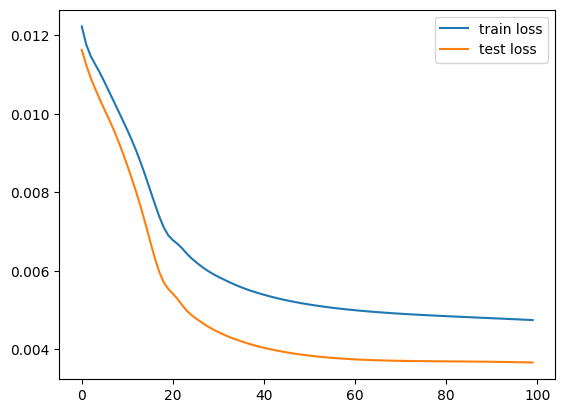

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [17]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [18]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [19]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [20]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [21]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

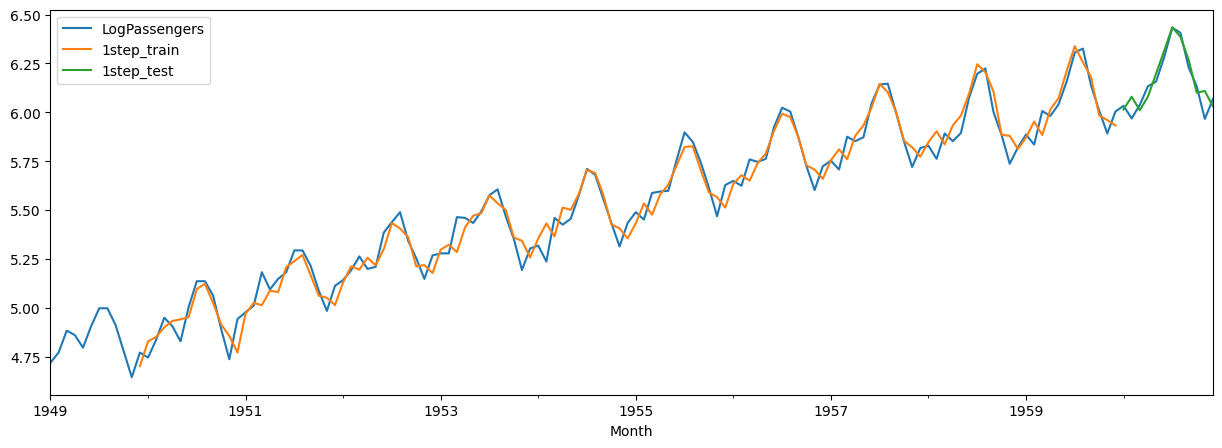

In [22]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [23]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0] # because LSTM interface takes data in N*T*D form

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1) # discarding oldest data and appending newest prediction
  last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [24]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

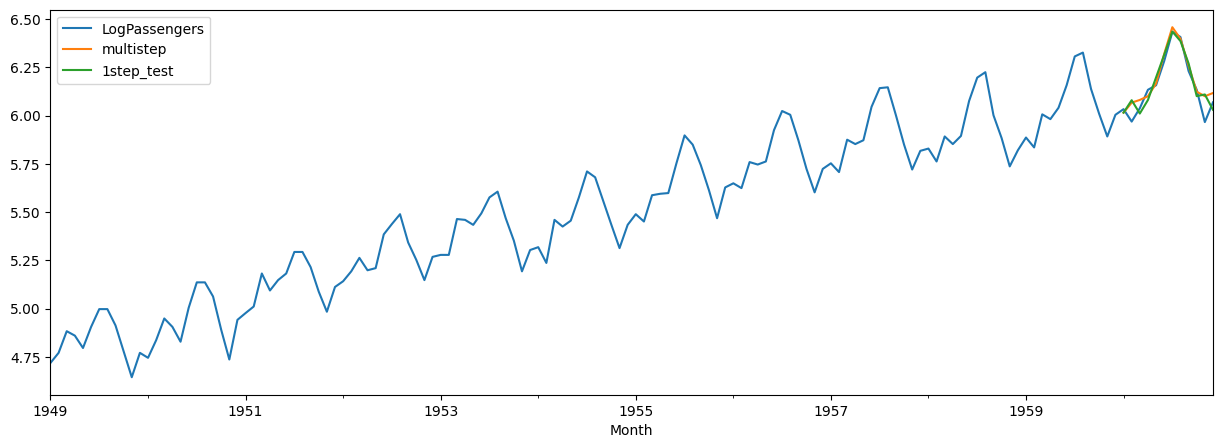

In [25]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [26]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1) # N * T * D
Y = np.array(Y).reshape(-1, Ty) # N * Multi-step horizon
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [27]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:] # Xtest_m and Ytest_m are just one row each

In [28]:
# RNN
i = Input(shape=(Tx, 1))
x = LSTM(24, return_sequences=True)(i) # Tx * 24
x = GlobalMaxPooling1D()(x) # 24
x = Dense(Ty)(x) # Ty
model = Model(i, x)

In [29]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 24)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,796 (10.92 KB)

 Trainable params: 2,796 (10.92 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [31]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [32]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 0.0119

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 10/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0112

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 11/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0111

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 12/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0110

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 13/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0109

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 14/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0108

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 15/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0107

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0105 - val_loss: 0.0099
Epoch 16/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0106

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 17/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0105

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 18/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0104

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 19/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0102

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 20/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0101

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 21/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0099

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 22/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0098

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 23/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0097

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 24/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0095

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 25/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0094

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 26/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0093

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 27/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0092

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 28/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0092

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 29/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0091

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 30/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0090

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 31/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0089

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 32/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0089

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 33/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0088

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 34/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0087

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 35/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0086

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 36/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0086

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 37/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0085

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 38/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0084

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 39/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0083

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 40/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0083

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 41/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0082

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 42/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0081

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 43/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0080

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 44/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0080

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 45/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0079

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 46/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0078

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 47/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0077

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 48/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0076

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 49/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0076

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 50/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0075

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 51/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0074

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 52/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0073

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 53/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0073

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 54/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0072

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 55/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0071

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 56/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0071

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 57/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0070

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 58/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0069

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 59/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0068

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 60/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0068

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 61/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0067

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 62/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0066

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 63/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0066

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 64/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0065

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 65/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0064

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 66/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0064

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 67/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0063

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 68/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0062

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 69/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0061

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 70/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0061

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 71/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0060

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 72/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0059

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 73/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0059

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 74/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0058

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 75/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0057

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 76/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0057

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 77/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0056

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 78/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0055

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 79/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0055

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 80/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0054

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 81/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0054

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 82/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0053

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 83/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0053

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 84/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0052

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 85/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0051

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 86/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0051

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 87/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0050

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 88/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0050

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 89/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0049

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 90/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0049

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 91/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 92/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0048

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 93/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0047

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 94/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0047

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 95/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0046

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 96/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0046

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 97/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 98/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0045

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 99/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0045

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 100/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 101/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 102/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 103/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 104/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 105/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0043

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 106/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0043

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 107/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0042

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 108/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 109/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0042

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 110/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 111/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 112/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 113/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 114/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 115/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 116/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0040

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 117/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 118/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 119/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 120/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 121/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 122/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 123/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 124/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 125/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 126/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 127/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 128/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 129/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 130/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 131/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 132/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 133/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 134/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 135/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 136/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 137/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 138/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 139/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 140/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 141/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 142/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 143/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 144/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 145/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0034

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 146/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0034

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 147/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0034

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 148/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 149/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 150/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 151/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0034

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 152/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0033

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 153/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 154/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 155/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 156/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0033

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 157/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 158/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0032

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 159/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 160/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 161/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0032

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 162/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0032

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 163/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 164/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0031

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 165/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 166/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 167/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 168/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0031

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 169/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 170/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 171/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 172/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 173/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 174/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 175/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 176/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0030

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 177/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 178/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 179/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 180/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 181/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 182/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0029

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 183/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0029

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 184/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 185/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0029

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 186/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 187/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 188/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 189/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0029

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 190/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 191/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 192/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 193/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0028

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 194/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 195/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0028

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 196/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 197/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 198/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0028

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 199/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 200/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 201/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 202/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 203/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 204/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 205/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 206/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 207/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 208/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 209/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027 -

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 215/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 216/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 217/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 218/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 219/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 220/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 221/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 222/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 223/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 224/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 225/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0025

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 226/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 227/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 228/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0025

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 229/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 230/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 231/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 232/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0025

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 233/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 234/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0024

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 235/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0024

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 236/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 237/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0024

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 238/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0024

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 239/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 240/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 241/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 242/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0024

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 243/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 244/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 245/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 246/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 247/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0023

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 248/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 249/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 250/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 251/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 252/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 253/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0023

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 254/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0023

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 255/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0023

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 256/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0023

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 257/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0023

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 258/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 259/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0023

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 260/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0022

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 261/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 262/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 263/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 264/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0022

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 265/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 266/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 267/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0022

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 268/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 269/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 270/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0022

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 271/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 272/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 273/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 274/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 275/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 276/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 277/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 278/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 279/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 280/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 281/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0021

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 282/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 283/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 284/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 285/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 286/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 287/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 288/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 289/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 290/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0021

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 291/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 292/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 293/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 294/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 295/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 296/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0020

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 297/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 298/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0020

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 299/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 300/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0021 - val_loss: 0.0024


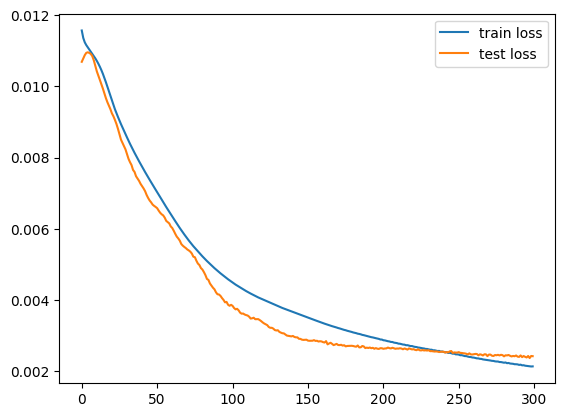

In [33]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [34]:
# load best model
# best_model = tf.keras.models.load_model('best_model.h5')
best_model = tf.keras.models.load_model('best_model.h5',custom_objects={ "mse": MeanSquaredError()})

In [35]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [36]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [37]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [38]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

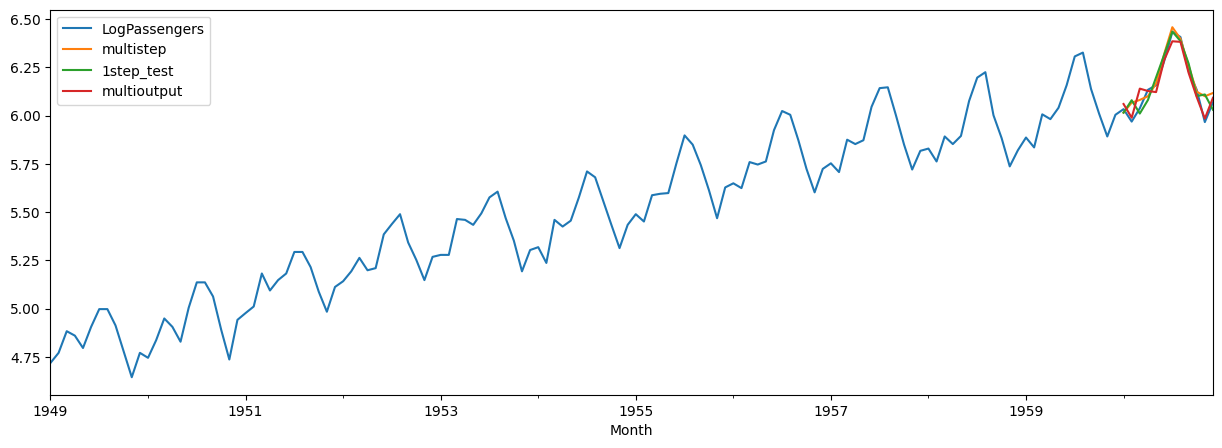

In [39]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [40]:
# RNN multiple LSTM layers
i = Input(shape=(Tx, 1))
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [41]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [42]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [43]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.0118

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 2/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0117

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 4/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0116

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 5/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0115

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 6/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0114

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 7/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0114

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 8/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0113

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 9/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0112

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 10/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0111

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 11/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0110

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 12/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0108

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 13/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0107

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 14/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0105

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 15/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0103

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 16/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0102

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 17/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0101

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 18/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0100

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 19/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0100

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 20/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0098

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 21/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 22/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 23/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 24/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 25/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 26/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 27/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 28/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 29/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 30/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 31/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0092 - val_loss: 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 42/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0086

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0085 - val_loss: 0.0092
Epoch 43/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0085

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0084 - val_loss: 0.0092
Epoch 44/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 45/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0084

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0083 - val_loss: 0.0091
Epoch 46/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0083

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0082 - val_loss: 0.0090
Epoch 47/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0082

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0081 - val_loss: 0.0089
Epoch 48/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0081 - val_loss: 0.0090
Epoch 49/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0081

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 50/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0080

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 51/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 52/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 53/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 54/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0077

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 55/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0076

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 56/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0076

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 57/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0075

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 58/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0074

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 59/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0074

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 60/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0073 - val_loss: 0.0079
Epoch 61/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0072

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0072 - val_loss: 0.0077
Epoch 62/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0072

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 63/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0071

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 64/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0070

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 65/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0069

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 66/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0068

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 67/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0068

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 68/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0067

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 69/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0066

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 70/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0065

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 71/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0064

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 72/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0063

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 73/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0063

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 74/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0062

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 75/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0061

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 76/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0060

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 77/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0060

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 78/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0059

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 79/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0059

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 80/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0058

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 81/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0058

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 82/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0057

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 83/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0057

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 84/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 85/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 86/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 87/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 88/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 89/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 90/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 91/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 92/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 93/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 94/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0052 - val_loss: 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 108/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 109/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 110/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 111/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0048

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 112/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0048

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 113/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0047

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 114/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0047

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 115/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 116/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0047

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 117/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0046

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 118/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0046

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 119/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0046

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 120/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0046

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 121/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0045

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 122/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0045

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 123/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0045

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 124/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 125/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0045

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 126/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 127/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 128/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 129/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 130/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 131/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0043

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 132/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0043

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 133/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0043

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 134/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 135/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0042

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 136/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0042

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 137/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0042

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 138/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0042

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 139/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0042

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 140/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 141/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 142/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 143/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 144/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 145/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0041

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 146/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0040

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 147/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0040

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 148/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0040

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 149/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0040

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 150/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0040

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 151/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0040

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 152/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0040

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 153/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 154/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 155/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 156/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 157/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 158/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0039

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 159/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 160/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 161/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 162/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 163/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 164/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 165/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 166/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0038

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 167/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 168/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 169/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 170/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 171/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 172/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 173/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 174/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 175/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 176/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 177/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 178/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 179/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 180/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 181/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0036

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 182/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 183/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 184/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 185/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 186/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 187/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 188/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 189/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 190/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0035

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 191/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 192/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 193/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 194/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 195/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 196/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0034

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 197/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0034

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 198/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 199/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 200/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 201/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 202/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 203/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 204/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0033

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 205/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 206/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 207/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 208/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0033

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 209/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 210/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0033

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 211/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 212/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 213/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 214/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 215/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 216/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0032

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 217/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 218/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 219/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 220/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 221/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 222/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 223/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 224/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 225/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 226/300
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 227/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 228/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 229/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 230/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 231/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 232/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 233/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 234/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 235/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 236/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 237/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0031 -

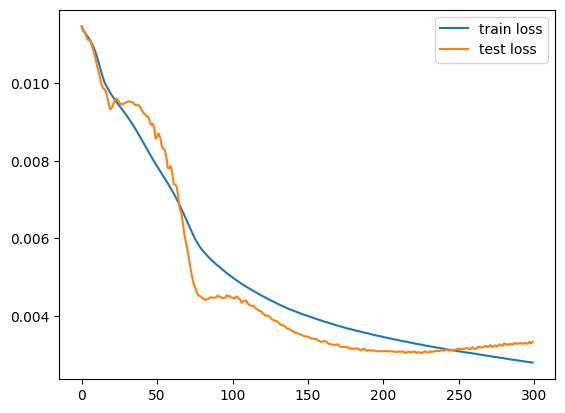

In [44]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [46]:
# load best model
# best_model = tf.keras.models.load_model('best_model.h5')
best_model = tf.keras.models.load_model('best_model.h5',custom_objects={ "mse": MeanSquaredError()})

In [47]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [48]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest)

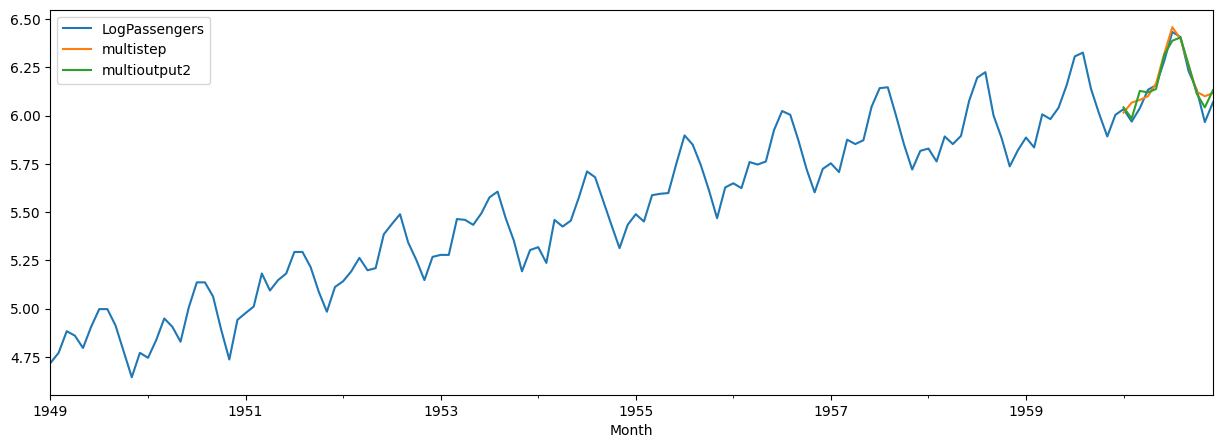

In [49]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', 'multioutput2']
df[cols].plot(figsize=(15, 5));

In [52]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
# Note that adding more LSTM layers led to WORSE RESULT in MAPE3 versus MAPE2
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-step MAPE: 0.006762963172976529
multi-output MAPE: 0.004839450577935678
multi-output (2 LSTMs) MAPE: 0.005712615968836873


In [ ]:
# Exercise:
# Is the improvement due to global max pooling? Or due to multiple LSTMs layers?
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?